# Tutorial: Optimising a Quantitative MRI Protocol Using Simulated Data

This notebook demonstrates how to use TADRED to optimise a quantitative or diffusion MRI protocol using simulated data. The code can be adapted to optimise protocols for your chosen model, whether it's an analytical model with an equation or another type.

To use your own model, simulate data using it while adhering to the key caveats outlined throughout this notebook.

### Key User-Defined Quantities:

1. **Protocol Length (`n_volumes_opt`)**: Define the number of acquisition parameters or acquired volumes for your optimised protocol.

2. **Number of Iterations (`n_iterations_tadred`)**: Set the number of iterations that TADRED will use during training. During each iteration, TADRED halves the size of the acquisition protocol. The default is 5, which typically works well.

3. **Number of Training Voxels (`n_train`)**: Specify the number of training voxels. Reduce this number for faster training or increase it for more accuracy.

### Simulation Requirements:

1. **Superdesign Size**: Parameters 1 and 2 determine the size of the superdesign required for simulations. In this tutorial, TADRED will sequentially halve the number of subsets. For example, with `n_volumes_opt=20` and `n_iterations_tadred=5`, the subsetting will be `[320, 160, 80, 40, 20]`. Therefore, the superdesign acquisition should include 320 acquisitions. The acquisition parameters of the superdesign should span the entire acquisition space from which optimal parameters will be selected. For instance, if your scanner has a maximum b-value of 3000, the superdesign might include 320 b-values equally spaced between 0 and 3000. This principle generalises to higher dimensions.

2. **Simulated Voxels**: Parameter 3 defines the number of simulated voxels needed. If `n_train=1000`, then 1200 voxels are required in total, as 100 voxels are allocated for the validation dataset and 100 for the test dataset.

Cell X provides an example of how to run the appropriate simulations for two simple models.

(c) Stefano B. Blumberg and Paddy J. Slator

### Cell 1: import packages and path 
Edit out_base to define where your data is, and/or where it will be stored.

In [1]:
########## (1)
# See requirements.txt for tadred requirements, make sure things are in the path, set global seed

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from tadred import tadred_main, utils

# Replace below with the directory where the data is, or where you want to save the data and results 
#out_base: str = '/home/blumberg/Bureau/z_Automated_Measurement/Output/journal_paper_tst' # ''
out_base: str = '/Users/paddyslator/python/ED/ED_MRI/examples'

Path(out_base).mkdir(parents=True, exist_ok=True)

# If TADRED is installed in another directory, add the location tobelow
# TADRED_dir: str = ''
# sys.path.append(TADRED_dir)

np.random.seed(0)  # Random seed for entire script

### Cell 2: set key user-defined quantities
* Edit n_volumes_opt_protocol to define the number of volumes in the desired optimized protocol.
* (Optional) Edit n_iterations_tadred to choose the number of TADRED iterations
* (Optional) Edit n_train_voxels to set the number of training voxels in the simulations.

In [2]:
# Define the number of acquisition volumes for the optimised protocol and the number TADRED iterations.
# Recall from paper we train on iteratively smaller volume sizes across a loop t = 1, ..., T
# This determines the length of the superdesign required for the training set, e.g. if n_iterations_tadred
# is 5 then the superdesign needs to be 16 times larger than the number of volumes in the optimised protocol

#these are the key user-defined options
n_volumes_opt_protocol = 20 #number of volumes in the desired optimized protocol
n_iterations_tadred = 5 # T in paper
n_train_voxels = 10**4  # Reduce for faster training speed

print("Your user-defined input parameters are:")
print("-" * 100)  
print(f"Length of desired optimized protocol: {n_volumes_opt_protocol}")
print(f"Number of TADRED iterations: {n_iterations_tadred}")
print(f"Number of training voxels: {n_train_voxels}")


# Calculate the required length of the superdesign, this depends on the number of 
# this depends on the number of TADRED iterations - which are always halvings - that will be done in tadred
Vbar = n_volumes_opt_protocol * 2**(n_iterations_tadred - 1) #

#calculate the required data split sizes
n_val_voxels = n_train_voxels // 10
n_test_voxels = n_train_voxels // 10
n_samples = n_train_voxels + n_val_voxels + n_test_voxels  # total number of samples to simulate

print("=" * 100) 
print("Your user-defined input parameters have been used to calculate the following values:")
print("-" * 100) 
print(f"Size of the required superdesign for the simulations: {Vbar}")
print(f"Number of validation voxels: {n_val_voxels}")
print(f"Number of test voxels: {n_test_voxels}")
print(f"Total number of simulated voxels: {n_samples}")


Your user-defined input parameters are:
----------------------------------------------------------------------------------------------------
Length of desired optimized protocol: 20
Number of TADRED iterations: 5
Number of training voxels: 10000
Your user-defined input parameters have been used to calculate the following values:
----------------------------------------------------------------------------------------------------
Size of the required superdesign for the simulations: 320
Number of validation voxels: 1000
Number of test voxels: 1000
Total number of simulated voxels: 12000


### Cell 3: choose whether to use your own simulated data 

* Set use_own_simulated_data to True to use your own simulated data  
* Set use_own_simulated_data to False and this notebook will generate example simulated data  

In [3]:
#use_own_simulated_data: bool = False #the notebook will create example simulated data
use_own_simulated_data: bool = True #the notebook will use your own simulated data


### Cell 4: guidelines for generating your own simulated data 


In [4]:
#If you are using your own simulated data, follow the guidelines to 
#generate simulated data that is appropriate for input to TADRED

# TODO this should be in the introduction where we define what the data looks like.  Or in a different repo.
    
if use_own_simulated_data:
    print(f"""
    To run TADRED, you need to simulate the following data:

    1. **Ground truth parameters** (size: n_samples x n_model_parameters)
       - n_samples: {n_samples}
       - n_model_parameters: The number of parameters in your model.

    2. **Simulated ground truth signals** using the superdesign acquisition scheme (size: n_samples x Vbar)
       - The superdesign acquisition scheme densely samples the acquisition parameter space, generating Vbar acquired measurements.
       - Vbar (number of measurements): {Vbar}

    3. **Acquisition parameters of the superdesign** (size: Vbar x n_acquisition_parameters)
       - n_acquisition_parameters: The number of dimensions in the acquisition parameter space (e.g., 4 [gx, gy, gz, b] for HCP data).

    Save these datasets as `.npy` files in a dedicated directory within **out_base**:
       - out_base directory: {out_base}
       - The subdirectory should match the project name (proj_name), as specified in the cell below.

    Suggested filenames for the files are:
       - Ground truth parameters: `parameters_gt_full.npy`
       - Simulated signals: `signals_super_full.npy`
       - Acquisition parameters: `acq_params_super.npy`
    """)
else:
    print("Run the cell below to simulate data suitable for TADRED.")




    To run TADRED, you need to simulate the following data:

    1. **Ground truth parameters** (size: n_samples x n_model_parameters)
       - n_samples: 12000
       - n_model_parameters: The number of parameters in your model.

    2. **Simulated ground truth signals** using the superdesign acquisition scheme (size: n_samples x Vbar)
       - The superdesign acquisition scheme densely samples the acquisition parameter space, generating Vbar acquired measurements.
       - Vbar (number of measurements): 320

    3. **Acquisition parameters of the superdesign** (size: Vbar x n_acquisition_parameters)
       - n_acquisition_parameters: The number of dimensions in the acquisition parameter space (e.g., 4 [gx, gy, gz, b] for HCP data).

    Save these datasets as `.npy` files in a dedicated directory within **out_base**:
       - out_base directory: /Users/paddyslator/python/ED/ED_MRI/examples
       - The subdirectory should match the project name (proj_name), as specified in the cell 

### Cell 5: Add paths to your own simulated data 
* Set proj_name to the subdirectory where you saved your simulated dataset
* (Optional) If you used different filenames to those suggested above, change simulation_gt_parameters_path, simulation_gt_signals_path, and acq_params_super_signals_path.

In [5]:
#If you are using your own simulated data, then update the filenames below 
if use_own_simulated_data:
    
    # Replace with name of the data directory, which needs to be in out_base
    proj_name: str = 't1inv_simulations_n_train_voxels_10000_SNR_20'
    # Replace with name of the directory where the data directory is
    proj_dir: str = Path(out_base, proj_name)

    # REPLACE WITH PATH TO SIMULATION GROUND TRUTH PARAMETERS
    # Saved array should be array n_samples by n_model_parameters     
    simulation_gt_parameters_path = Path(proj_dir,'parameters_gt_full.npy')

    # REPLACE WITH PATH TO SIMULATION GROUND TRUTH SIGNALS WITH "SUPER-DESIGN" ACQUISITION - HIGHLY OVERSAMPLING THE ACQUISITION PARAMETER SPACE
    # Array is n_samples by V_bar
    simulation_gt_signals_path = Path(proj_dir, 'signals_super_full.npy')

    # REPLACE WITH PATH TO SUPER-DESIGN ACQUISITION PARAMETERS
    # acq_params_super - Vbar by n_acqusition_parameters length array containing the acquisition parameters of the superdesign
    # Array is Vbar by n_acqusition_parameters, e.g. n_acqusition_parameters is 4 (gx, gy, gz, b) for HCP data
    acq_params_super_signals_path = Path(proj_dir, 'acq_params_super.npy')
    

### Cell 6: Load simulated data or simulate data

In [6]:
#if using your own simulated data it gets loaded here.
if use_own_simulated_data:   
    # Load the files
    parameters = np.load(simulation_gt_parameters_path)
    signals_super = np.load(simulation_gt_signals_path)
    acq_params_super = np.load(acq_params_super_signals_path)

    
#or otherwise generate some simple simulated data
if not use_own_simulated_data:
# Define some models and generate data
# Data that will be generated is:
#   parameters - n_samples by n_model_parameters  array containing the ground truth model parameters, where n_parameters is the number of parameters in your model
#   signals - n_samples by Vbar array containing the corresponding simulated signals from the model 
#   acq_params_super - Vbar by n_acqusition_parameters length array containing the acquisition parameters of the superdesign

    model_name = 't1inv' # T1 inversion recovery model
    # model_name = "adc" # ADC model
    SNR: int = 20
    proj_name = f"{model_name}_simulations_n_train_voxels_{n_train_voxels}_SNR_{SNR}"
    proj_dir = Path(out_base, proj_name)
    Path.mkdir(proj_dir, exist_ok=True, parents=True)

        
    if model_name == "adc":
        def model(D, bvals):
            signals = np.exp(-bvals * D)
            return signals
    
        # min/max parameter values
        minD = 0.1
        maxD = 3
    
        # Simulate parameter values
        parameters = np.random.uniform(low=minD, high=maxD, size=(n_samples, 1))
    
        ### Generate data using the model
    
        # Make super design
        maxb = 5
        minb = 0
        acq_params_super = np.linspace(minb, maxb, Vbar)
    
        # Generate data
        raw_signals = np.zeros((n_samples, Vbar), dtype=np.float32)
        for i in range(0, n_samples):
            raw_signals[i, :] = model(parameters[i], acq_params_super)
    
    elif model_name == "t1inv":
    
        def model(T1, ti, tr):
            signals = abs(1 - (2 * np.exp(-ti / T1)) + np.exp(-tr / T1))
            return signals
    
        # min/max parameter values
        minT1 = 0.1
        maxT1 = 7
        # Simulate parameter values
        parameters = np.random.uniform(low=minT1, high=maxT1, size=(n_samples, 1))
        
        # Make the super design
        tr = 7  # repetition time
        maxti = tr
        minti = 0.1
        acq_params_super = np.linspace(minti, maxti, Vbar)
    
        # Generate the data
        raw_signals = np.zeros((n_samples, Vbar), dtype=np.float32)
        for i in range(0, n_samples):
            raw_signals[i, :] = model(parameters[i], acq_params_super, tr)

    # Add Rician noise to the data
    def add_noise(data, scale=0.05):
        data_real = data + np.random.normal(scale=scale, size=np.shape(data))
        data_imag = np.random.normal(scale=scale, size=np.shape(data))
        data_noisy = np.sqrt(data_real**2 + data_imag**2)
    
        return data_noisy
    
    signals_super = add_noise(raw_signals, 1 / SNR)

    #save the simulated signals
    np.save(Path(proj_dir, "parameters_gt_full.npy"), parameters)
    np.save(Path(proj_dir, "signals_super_full.npy"), signals_super)
    np.save(Path(proj_dir, "acq_params_super.npy"), acq_params_super)
    


### Cell 7: Put data into TADRED format

In [7]:
# Data in TADRED format, \bar{V} volumes, M target regresors
data = dict(
    train=signals_super[0:n_train_voxels, :],  # Shape n_train_voxels x \bar{C}
    train_tar=parameters[0:n_train_voxels, :],  # Shape n_train_voxels x M
    val=signals_super[n_train_voxels : (n_train_voxels + n_val_voxels), :],  # Shape n_val_voxels x \bar{C}
    val_tar=parameters[n_train_voxels : (n_train_voxels + n_val_voxels), :],  # Shape n_val_voxels x M
    test=signals_super[(n_train_voxels + n_val_voxels): , :],  # Shape n_test_voxels x \bar{C}
    test_tar=parameters[(n_train_voxels + n_val_voxels):, :],  # Shape n_test_voxels x M
)

for key, value in data.items():
    data[key] = value.astype(np.float32)

# Save data to disk -- optional
np.save(Path(proj_dir, 'data'), data)    


### Cell 8: Run TADRED

In [8]:
# Simplest version of TADRED, modifying the most important hyperparameters.
# The decreasing subset sizes are hard-coded so final optimized protocol is 1/(2^n_iterations_tadred) the size of the superdesign
# Whilst you can play around with the subset size reduction pattern, halving the 
# size of the subset sizes at each TADRED step seems to generally work well.

args = utils.load_base_args()

# Set decreasing subset sizes
args.tadred_train_eval.feature_set_sizes_Ci = [Vbar // (2**i) for i in range(n_iterations_tadred)]
args.tadred_train_eval.feature_set_sizes_evaluated = [Vbar // (2**i) for i in range(1, n_iterations_tadred)]

# Scoring net Vbar -> num_units_score[0] -> num_units_score[1] ... -> Vbar units
args.network.num_units_score: list[int] = [1000, 1000]

# Task net Vbar -> num_units_task[0] -> num_units_task[1] ... -> M units
args.network.num_units_task: list[int] = [1000, 1000]

# SBB TODO add Pathlib option to tadred.utils.py:create_out_dirs
args.output.out_base = str(out_base)  # "/Users/paddyslator/python/ED_MRI/test1" #"/home/blumberg/Bureau/z_Automated_Measurement/Output/paddy"
args.output.proj_name = str(proj_name)
args.output.run_name = "test"
args.other_options.save_output = True

#print(args)

args.tadred_train_eval.epochs = 50

print(out_base, proj_name)

TADRED_output = tadred_main.run(args, data)


INFO:tadred.data_processing:concatenated ['train'] on voxel dim
INFO:tadred.data_processing:Target data found
INFO:tadred.data_processing:concatenated ['val'] on voxel dim
INFO:tadred.data_processing:Target data found
INFO:tadred.data_processing:concatenated ['test'] on voxel dim
INFO:tadred.data_processing:Target data found
INFO:tadred.tadred_main:data_norm:
  data_fil: null
  data_train_subjs:
  - train
  data_val_subjs:
  - val
  data_test_subjs:
  - test
  data_normalization: original-measurement
output:
  out_base: /Users/paddyslator/python/ED/ED_MRI/examples
  proj_name: t1inv_simulations_n_train_voxels_10000_SNR_20
  run_name: test
network:
  num_units_score:
  - 1000
  - 1000
  num_units_task:
  - 1000
  - 1000
  score_activation: doublesigmoid
tadred_train_eval:
  feature_set_sizes_Ci:
  - 320
  - 160
  - 80
  - 40
  - 20
  feature_set_sizes_evaluated:
  - 160
  - 80
  - 40
  - 20
  epochs: 50
  epochs_fix_sigma: 25
  epochs_decay_sigma: 10
  epochs_decay: 10
train_pytorch:
  

/Users/paddyslator/python/ED/ED_MRI/examples t1inv_simulations_n_train_voxels_10000_SNR_20
Epoch:0 train_loss:9.161 val_loss:4.879 time:0.306
Epoch:1 train_loss:3.046 val_loss:1.876 time:0.261
Epoch:2 train_loss:1.615 val_loss:1.291 time:0.263
Epoch:3 train_loss:1.071 val_loss:0.718 time:0.262
Epoch:4 train_loss:0.717 val_loss:0.536 time:0.264
Epoch:5 train_loss:0.492 val_loss:0.361 time:0.268
Epoch:6 train_loss:0.325 val_loss:0.232 time:0.264
Epoch:7 train_loss:0.221 val_loss:0.166 time:0.272
Epoch:8 train_loss:0.153 val_loss:0.119 time:0.270
Epoch:9 train_loss:0.109 val_loss:0.087 time:0.262
Epoch:10 train_loss:0.081 val_loss:0.066 time:0.286
Epoch:11 train_loss:0.063 val_loss:0.050 time:0.265
Epoch:12 train_loss:0.050 val_loss:0.042 time:0.321
Epoch:13 train_loss:0.042 val_loss:0.039 time:0.271
Epoch:14 train_loss:0.036 val_loss:0.033 time:0.286
Epoch:15 train_loss:0.031 val_loss:0.028 time:0.283
Epoch:16 train_loss:0.028 val_loss:0.025 time:0.280
Epoch:17 train_loss:0.025 val_loss:

INFO:tadred.networks:Trigger epochs_fix_sigma
INFO:tadred.networks:sigma_bar = 0.5*(sigma_bar+sigma_average)
INFO:tadred.networks:Decay sigma_mult 0.949999988079071


Epoch:23 train_loss:0.018 val_loss:0.018 time:0.266


INFO:tadred.networks:Decay sigma_mult 0.8999999761581421


Epoch:24 train_loss:0.020 val_loss:0.019 time:0.265


INFO:tadred.networks:Decay sigma_mult 0.8499999642372131


Epoch:25 train_loss:0.019 val_loss:0.019 time:0.269


INFO:tadred.networks:Decay sigma_mult 0.7999999523162842


Epoch:26 train_loss:0.021 val_loss:0.020 time:0.270


INFO:tadred.networks:Decay sigma_mult 0.7499999403953552


Epoch:27 train_loss:0.020 val_loss:0.019 time:0.267


INFO:tadred.networks:Decay sigma_mult 0.6999999284744263


Epoch:28 train_loss:0.021 val_loss:0.020 time:0.263


INFO:tadred.networks:Decay sigma_mult 0.6499999165534973


Epoch:29 train_loss:0.021 val_loss:0.020 time:0.261


INFO:tadred.networks:Decay sigma_mult 0.5999999046325684


Epoch:30 train_loss:0.022 val_loss:0.021 time:0.272


INFO:tadred.networks:Decay sigma_mult 0.5499998927116394


Epoch:31 train_loss:0.023 val_loss:0.022 time:0.272


INFO:tadred.networks:Decay sigma_mult 0.49999988079071045


Epoch:32 train_loss:0.023 val_loss:0.023 time:0.273


INFO:tadred.networks:Decay sigma_mult 0.4499998688697815


Epoch:33 train_loss:0.024 val_loss:0.024 time:0.280


INFO:tadred.networks:Decay sigma_mult 0.39999985694885254


Epoch:34 train_loss:0.026 val_loss:0.025 time:0.265


INFO:tadred.networks:Decay sigma_mult 0.3499998450279236


Epoch:35 train_loss:0.027 val_loss:0.026 time:0.280


INFO:tadred.networks:Decay sigma_mult 0.29999983310699463


Epoch:36 train_loss:0.029 val_loss:0.027 time:0.304


INFO:tadred.networks:Decay sigma_mult 0.24999983608722687


Epoch:37 train_loss:0.030 val_loss:0.029 time:0.264


INFO:tadred.networks:Decay sigma_mult 0.1999998390674591


Epoch:38 train_loss:0.033 val_loss:0.031 time:0.265


INFO:tadred.networks:Decay sigma_mult 0.14999984204769135


Epoch:39 train_loss:0.035 val_loss:0.033 time:0.263


INFO:tadred.networks:Decay sigma_mult 0.09999984502792358


Epoch:40 train_loss:0.038 val_loss:0.035 time:0.264


INFO:tadred.networks:Decay sigma_mult 0.049999844282865524


Epoch:41 train_loss:0.042 val_loss:0.038 time:0.264


INFO:tadred.networks:Decay sigma_mult 0.0


Epoch:42 train_loss:0.046 val_loss:0.042 time:0.266
Epoch:43 train_loss:0.050 val_loss:0.045 time:0.280
Epoch:44 train_loss:0.042 val_loss:0.036 time:0.293
Epoch:45 train_loss:0.037 val_loss:0.038 time:0.265


INFO:tadred.trainer:Cached best_state_dict


Epoch:46 train_loss:0.034 val_loss:0.031 time:0.266


INFO:tadred.trainer:Cached best_state_dict


Epoch:47 train_loss:0.031 val_loss:0.030 time:0.262


INFO:tadred.trainer:Cached best_state_dict


Epoch:48 train_loss:0.029 val_loss:0.030 time:0.326


INFO:tadred.trainer:Cached best_state_dict
INFO:tadred.trainer:
Finished training step 1 
m = 320 
step time:13.721
INFO:tadred.networks:m has 320 ones and 0 zeros
INFO:tadred.networks:sigma_mult 0.5
INFO:tadred.networks:Decay: 160.0 measurements in NAS step 2


Epoch:49 train_loss:0.028 val_loss:0.028 time:0.257
Epoch:0 train_loss:2.679 val_loss:2.092 time:0.269
Epoch:1 train_loss:1.051 val_loss:0.224 time:0.267
Epoch:2 train_loss:0.431 val_loss:0.112 time:0.289
Epoch:3 train_loss:0.186 val_loss:0.230 time:0.280
Epoch:4 train_loss:0.118 val_loss:0.104 time:0.275
Epoch:5 train_loss:0.069 val_loss:0.041 time:0.267
Epoch:6 train_loss:0.043 val_loss:0.027 time:0.268
Epoch:7 train_loss:0.028 val_loss:0.028 time:0.263
Epoch:8 train_loss:0.025 val_loss:0.027 time:0.265
Epoch:9 train_loss:0.022 val_loss:0.021 time:0.284
Epoch:10 train_loss:0.020 val_loss:0.020 time:0.313
Epoch:11 train_loss:0.019 val_loss:0.020 time:0.280
Epoch:12 train_loss:0.018 val_loss:0.019 time:0.274
Epoch:13 train_loss:0.018 val_loss:0.019 time:0.285
Epoch:14 train_loss:0.018 val_loss:0.019 time:0.267
Epoch:15 train_loss:0.017 val_loss:0.018 time:0.272
Epoch:16 train_loss:0.017 val_loss:0.018 time:0.267
Epoch:17 train_loss:0.017 val_loss:0.018 time:0.276
Epoch:18 train_loss:0.

INFO:tadred.networks:Trigger epochs_fix_sigma
INFO:tadred.networks:sigma_bar = 0.5*(sigma_bar+sigma_average)
INFO:tadred.networks:Decay sigma_mult 0.44999998807907104


Epoch:23 train_loss:0.016 val_loss:0.018 time:0.268


INFO:tadred.networks:Decay sigma_mult 0.3999999761581421


Epoch:24 train_loss:0.055 val_loss:0.026 time:0.307


INFO:tadred.networks:Decay sigma_mult 0.34999996423721313


Epoch:25 train_loss:0.044 val_loss:0.029 time:0.268


INFO:tadred.networks:Decay sigma_mult 0.2999999523162842


Epoch:26 train_loss:0.037 val_loss:0.036 time:0.269


INFO:tadred.networks:Decay sigma_mult 0.24999995529651642


Epoch:27 train_loss:0.023 val_loss:0.022 time:0.269


INFO:tadred.networks:Decay sigma_mult 0.19999995827674866


Epoch:28 train_loss:0.028 val_loss:0.024 time:0.269


INFO:tadred.networks:Decay sigma_mult 0.1499999612569809


Epoch:29 train_loss:0.027 val_loss:0.026 time:0.266


INFO:tadred.networks:Decay sigma_mult 0.09999996423721313


Epoch:30 train_loss:0.026 val_loss:0.026 time:0.287


INFO:tadred.networks:Decay sigma_mult 0.049999963492155075


Epoch:31 train_loss:0.030 val_loss:0.027 time:0.303


INFO:tadred.networks:Decay sigma_mult 0.0


Epoch:32 train_loss:0.033 val_loss:0.029 time:0.311


INFO:tadred.networks:Decay measurements


Epoch:33 train_loss:0.034 val_loss:0.031 time:0.314


INFO:tadred.networks:Decay measurements


Epoch:34 train_loss:0.028 val_loss:0.027 time:0.308


INFO:tadred.networks:Decay measurements


Epoch:35 train_loss:0.022 val_loss:0.022 time:0.312


INFO:tadred.networks:Decay measurements


Epoch:36 train_loss:0.018 val_loss:0.017 time:0.316


INFO:tadred.networks:Decay measurements


Epoch:37 train_loss:0.015 val_loss:0.016 time:0.324


INFO:tadred.networks:Decay measurements


Epoch:38 train_loss:0.014 val_loss:0.014 time:0.298


INFO:tadred.networks:Decay measurements


Epoch:39 train_loss:0.013 val_loss:0.013 time:0.297


INFO:tadred.networks:Decay measurements


Epoch:40 train_loss:0.011 val_loss:0.011 time:0.268


INFO:tadred.networks:Decay measurements


Epoch:41 train_loss:0.011 val_loss:0.011 time:0.292


INFO:tadred.networks:Decay measurements


Epoch:42 train_loss:0.010 val_loss:0.010 time:0.283
Epoch:43 train_loss:0.010 val_loss:0.009 time:0.286
Epoch:44 train_loss:0.009 val_loss:0.009 time:0.284
Epoch:45 train_loss:0.008 val_loss:0.008 time:0.278


INFO:tadred.trainer:Cached best_state_dict


Epoch:46 train_loss:0.008 val_loss:0.008 time:0.297


INFO:tadred.trainer:Cached best_state_dict


Epoch:47 train_loss:0.008 val_loss:0.008 time:0.289


INFO:tadred.trainer:Cached best_state_dict


Epoch:48 train_loss:0.008 val_loss:0.008 time:0.278


INFO:tadred.trainer:Cached best_state_dict
INFO:tadred.trainer:
Finished training step 2 
m = 160 
step time:14.172
INFO:tadred.trainer:m 160 ones 160 zeros
INFO:tadred.trainer:m 160 ones 160 zeros
INFO:tadred.trainer:val_joint 0.008045299910008907 test_joint 0.007385765668004751
INFO:tadred.networks:m has 160 ones and 160 zeros
INFO:tadred.networks:sigma_mult 0.5
INFO:tadred.networks:Decay: 80.0 measurements in NAS step 3


Epoch:49 train_loss:0.008 val_loss:0.008 time:0.269
Epoch:0 train_loss:0.588 val_loss:0.315 time:0.346
Epoch:1 train_loss:0.240 val_loss:0.248 time:0.290
Epoch:2 train_loss:0.153 val_loss:0.042 time:0.278
Epoch:3 train_loss:0.059 val_loss:0.033 time:0.285
Epoch:4 train_loss:0.033 val_loss:0.040 time:0.304
Epoch:5 train_loss:0.024 val_loss:0.018 time:0.287
Epoch:6 train_loss:0.015 val_loss:0.009 time:0.270
Epoch:7 train_loss:0.010 val_loss:0.010 time:0.268
Epoch:8 train_loss:0.009 val_loss:0.009 time:0.297
Epoch:9 train_loss:0.008 val_loss:0.007 time:0.332
Epoch:10 train_loss:0.007 val_loss:0.007 time:0.289
Epoch:11 train_loss:0.007 val_loss:0.007 time:0.286
Epoch:12 train_loss:0.007 val_loss:0.007 time:0.294
Epoch:13 train_loss:0.006 val_loss:0.007 time:0.299
Epoch:14 train_loss:0.006 val_loss:0.006 time:0.387
Epoch:15 train_loss:0.006 val_loss:0.006 time:0.309
Epoch:16 train_loss:0.006 val_loss:0.006 time:0.300
Epoch:17 train_loss:0.006 val_loss:0.006 time:0.317
Epoch:18 train_loss:0.

INFO:tadred.networks:Trigger epochs_fix_sigma
INFO:tadred.networks:sigma_bar = 0.5*(sigma_bar+sigma_average)
INFO:tadred.networks:Decay sigma_mult 0.44999998807907104


Epoch:23 train_loss:0.006 val_loss:0.006 time:0.297


INFO:tadred.networks:Decay sigma_mult 0.3999999761581421


Epoch:24 train_loss:0.010 val_loss:0.008 time:0.305


INFO:tadred.networks:Decay sigma_mult 0.34999996423721313


Epoch:25 train_loss:0.008 val_loss:0.007 time:0.324


INFO:tadred.networks:Decay sigma_mult 0.2999999523162842


Epoch:26 train_loss:0.007 val_loss:0.007 time:0.314


INFO:tadred.networks:Decay sigma_mult 0.24999995529651642


Epoch:27 train_loss:0.008 val_loss:0.008 time:0.339


INFO:tadred.networks:Decay sigma_mult 0.19999995827674866


Epoch:28 train_loss:0.008 val_loss:0.007 time:0.316


INFO:tadred.networks:Decay sigma_mult 0.1499999612569809


Epoch:29 train_loss:0.008 val_loss:0.008 time:0.312


INFO:tadred.networks:Decay sigma_mult 0.09999996423721313


Epoch:30 train_loss:0.008 val_loss:0.008 time:0.315


INFO:tadred.networks:Decay sigma_mult 0.049999963492155075


Epoch:31 train_loss:0.009 val_loss:0.009 time:0.300


INFO:tadred.networks:Decay sigma_mult 0.0


Epoch:32 train_loss:0.010 val_loss:0.009 time:0.270


INFO:tadred.networks:Decay measurements


Epoch:33 train_loss:0.010 val_loss:0.010 time:0.270


INFO:tadred.networks:Decay measurements


Epoch:34 train_loss:0.010 val_loss:0.010 time:0.272


INFO:tadred.networks:Decay measurements


Epoch:35 train_loss:0.010 val_loss:0.010 time:0.268


INFO:tadred.networks:Decay measurements


Epoch:36 train_loss:0.011 val_loss:0.010 time:0.274


INFO:tadred.networks:Decay measurements


Epoch:37 train_loss:0.012 val_loss:0.011 time:0.285


INFO:tadred.networks:Decay measurements


Epoch:38 train_loss:0.012 val_loss:0.011 time:0.309


INFO:tadred.networks:Decay measurements


Epoch:39 train_loss:0.013 val_loss:0.012 time:0.342


INFO:tadred.networks:Decay measurements


Epoch:40 train_loss:0.014 val_loss:0.012 time:0.293


INFO:tadred.networks:Decay measurements


Epoch:41 train_loss:0.014 val_loss:0.013 time:0.303


INFO:tadred.networks:Decay measurements


Epoch:42 train_loss:0.016 val_loss:0.014 time:0.305
Epoch:43 train_loss:0.017 val_loss:0.015 time:0.312
Epoch:44 train_loss:0.015 val_loss:0.013 time:0.353
Epoch:45 train_loss:0.014 val_loss:0.013 time:0.292


INFO:tadred.trainer:Cached best_state_dict


Epoch:46 train_loss:0.013 val_loss:0.012 time:0.270


INFO:tadred.trainer:Cached best_state_dict


Epoch:47 train_loss:0.013 val_loss:0.012 time:0.271


INFO:tadred.trainer:Cached best_state_dict


Epoch:48 train_loss:0.012 val_loss:0.011 time:0.264


INFO:tadred.trainer:Cached best_state_dict
INFO:tadred.trainer:
Finished training step 3 
m = 80 
step time:15.043
INFO:tadred.trainer:m 80 ones 240 zeros
INFO:tadred.trainer:m 80 ones 240 zeros
INFO:tadred.trainer:val_joint 0.01090976595878601 test_joint 0.010447757318615913
INFO:tadred.networks:m has 80 ones and 240 zeros
INFO:tadred.networks:sigma_mult 0.5
INFO:tadred.networks:Decay: 40.0 measurements in NAS step 4


Epoch:49 train_loss:0.012 val_loss:0.011 time:0.276
Epoch:0 train_loss:0.270 val_loss:0.288 time:0.296
Epoch:1 train_loss:0.123 val_loss:0.057 time:0.297
Epoch:2 train_loss:0.066 val_loss:0.036 time:0.289
Epoch:3 train_loss:0.035 val_loss:0.023 time:0.308
Epoch:4 train_loss:0.021 val_loss:0.013 time:0.269
Epoch:5 train_loss:0.012 val_loss:0.014 time:0.283
Epoch:6 train_loss:0.010 val_loss:0.008 time:0.275
Epoch:7 train_loss:0.009 val_loss:0.007 time:0.270
Epoch:8 train_loss:0.008 val_loss:0.007 time:0.271
Epoch:9 train_loss:0.007 val_loss:0.007 time:0.298
Epoch:10 train_loss:0.007 val_loss:0.006 time:0.293
Epoch:11 train_loss:0.007 val_loss:0.006 time:0.302
Epoch:12 train_loss:0.006 val_loss:0.006 time:0.293
Epoch:13 train_loss:0.006 val_loss:0.006 time:0.286
Epoch:14 train_loss:0.006 val_loss:0.006 time:0.291
Epoch:15 train_loss:0.006 val_loss:0.006 time:0.286
Epoch:16 train_loss:0.006 val_loss:0.006 time:0.306
Epoch:17 train_loss:0.006 val_loss:0.006 time:0.313
Epoch:18 train_loss:0.

INFO:tadred.networks:Trigger epochs_fix_sigma
INFO:tadred.networks:sigma_bar = 0.5*(sigma_bar+sigma_average)
INFO:tadred.networks:Decay sigma_mult 0.44999998807907104


Epoch:23 train_loss:0.006 val_loss:0.005 time:0.308


INFO:tadred.networks:Decay sigma_mult 0.3999999761581421


Epoch:24 train_loss:0.012 val_loss:0.012 time:0.313


INFO:tadred.networks:Decay sigma_mult 0.34999996423721313


Epoch:25 train_loss:0.010 val_loss:0.007 time:0.304


INFO:tadred.networks:Decay sigma_mult 0.2999999523162842


Epoch:26 train_loss:0.010 val_loss:0.007 time:0.304


INFO:tadred.networks:Decay sigma_mult 0.24999995529651642


Epoch:27 train_loss:0.008 val_loss:0.007 time:0.295


INFO:tadred.networks:Decay sigma_mult 0.19999995827674866


Epoch:28 train_loss:0.009 val_loss:0.008 time:0.329


INFO:tadred.networks:Decay sigma_mult 0.1499999612569809


Epoch:29 train_loss:0.010 val_loss:0.009 time:0.299


INFO:tadred.networks:Decay sigma_mult 0.09999996423721313


Epoch:30 train_loss:0.011 val_loss:0.010 time:0.305


INFO:tadred.networks:Decay sigma_mult 0.049999963492155075


Epoch:31 train_loss:0.012 val_loss:0.011 time:0.316


INFO:tadred.networks:Decay sigma_mult 0.0


Epoch:32 train_loss:0.013 val_loss:0.012 time:0.314


INFO:tadred.networks:Decay measurements


Epoch:33 train_loss:0.015 val_loss:0.013 time:0.310


INFO:tadred.networks:Decay measurements


Epoch:34 train_loss:0.016 val_loss:0.015 time:0.311


INFO:tadred.networks:Decay measurements


Epoch:35 train_loss:0.017 val_loss:0.015 time:0.304


INFO:tadred.networks:Decay measurements


Epoch:36 train_loss:0.019 val_loss:0.017 time:0.324


INFO:tadred.networks:Decay measurements


Epoch:37 train_loss:0.020 val_loss:0.019 time:0.300


INFO:tadred.networks:Decay measurements


Epoch:38 train_loss:0.022 val_loss:0.021 time:0.294


INFO:tadred.networks:Decay measurements


Epoch:39 train_loss:0.025 val_loss:0.024 time:0.295


INFO:tadred.networks:Decay measurements


Epoch:40 train_loss:0.027 val_loss:0.026 time:0.305


INFO:tadred.networks:Decay measurements


Epoch:41 train_loss:0.030 val_loss:0.027 time:0.290


INFO:tadred.networks:Decay measurements


Epoch:42 train_loss:0.033 val_loss:0.026 time:0.331
Epoch:43 train_loss:0.035 val_loss:0.026 time:0.296
Epoch:44 train_loss:0.029 val_loss:0.023 time:0.284
Epoch:45 train_loss:0.026 val_loss:0.022 time:0.293


INFO:tadred.trainer:Cached best_state_dict


Epoch:46 train_loss:0.023 val_loss:0.021 time:0.292


INFO:tadred.trainer:Cached best_state_dict


Epoch:47 train_loss:0.022 val_loss:0.020 time:0.295


INFO:tadred.trainer:Cached best_state_dict


Epoch:48 train_loss:0.020 val_loss:0.019 time:0.303


INFO:tadred.trainer:Cached best_state_dict
INFO:tadred.trainer:
Finished training step 4 
m = 40 
step time:15.021
INFO:tadred.trainer:m 40 ones 280 zeros
INFO:tadred.trainer:m 40 ones 280 zeros
INFO:tadred.trainer:val_joint 0.018177824094891548 test_joint 0.019034292548894882
INFO:tadred.networks:m has 40 ones and 280 zeros
INFO:tadred.networks:sigma_mult 0.5
INFO:tadred.networks:Decay: 20.0 measurements in NAS step 5


Epoch:49 train_loss:0.019 val_loss:0.018 time:0.295
Epoch:0 train_loss:0.410 val_loss:0.332 time:0.286
Epoch:1 train_loss:0.161 val_loss:0.124 time:0.289
Epoch:2 train_loss:0.090 val_loss:0.060 time:0.295
Epoch:3 train_loss:0.045 val_loss:0.039 time:0.286
Epoch:4 train_loss:0.027 val_loss:0.018 time:0.290
Epoch:5 train_loss:0.019 val_loss:0.010 time:0.283
Epoch:6 train_loss:0.012 val_loss:0.009 time:0.297
Epoch:7 train_loss:0.010 val_loss:0.008 time:0.289
Epoch:8 train_loss:0.008 val_loss:0.008 time:0.277
Epoch:9 train_loss:0.008 val_loss:0.007 time:0.285
Epoch:10 train_loss:0.007 val_loss:0.007 time:0.293
Epoch:11 train_loss:0.007 val_loss:0.007 time:0.292
Epoch:12 train_loss:0.006 val_loss:0.006 time:0.306
Epoch:13 train_loss:0.006 val_loss:0.006 time:0.310
Epoch:14 train_loss:0.006 val_loss:0.006 time:0.312
Epoch:15 train_loss:0.006 val_loss:0.006 time:0.306
Epoch:16 train_loss:0.006 val_loss:0.006 time:0.313
Epoch:17 train_loss:0.006 val_loss:0.006 time:0.311
Epoch:18 train_loss:0.

INFO:tadred.networks:Trigger epochs_fix_sigma
INFO:tadred.networks:sigma_bar = 0.5*(sigma_bar+sigma_average)
INFO:tadred.networks:Decay sigma_mult 0.44999998807907104


Epoch:23 train_loss:0.006 val_loss:0.005 time:0.298


INFO:tadred.networks:Decay sigma_mult 0.3999999761581421


Epoch:24 train_loss:0.031 val_loss:0.034 time:0.299


INFO:tadred.networks:Decay sigma_mult 0.34999996423721313


Epoch:25 train_loss:0.020 val_loss:0.023 time:0.318


INFO:tadred.networks:Decay sigma_mult 0.2999999523162842


Epoch:26 train_loss:0.018 val_loss:0.019 time:0.318


INFO:tadred.networks:Decay sigma_mult 0.24999995529651642


Epoch:27 train_loss:0.016 val_loss:0.017 time:0.318


INFO:tadred.networks:Decay sigma_mult 0.19999995827674866


Epoch:28 train_loss:0.015 val_loss:0.014 time:0.325


INFO:tadred.networks:Decay sigma_mult 0.1499999612569809


Epoch:29 train_loss:0.016 val_loss:0.015 time:0.326


INFO:tadred.networks:Decay sigma_mult 0.09999996423721313


Epoch:30 train_loss:0.017 val_loss:0.016 time:0.325


INFO:tadred.networks:Decay sigma_mult 0.049999963492155075


Epoch:31 train_loss:0.020 val_loss:0.019 time:0.309


INFO:tadred.networks:Decay sigma_mult 0.0


Epoch:32 train_loss:0.023 val_loss:0.022 time:0.362


INFO:tadred.networks:Decay measurements


Epoch:33 train_loss:0.028 val_loss:0.026 time:0.317


INFO:tadred.networks:Decay measurements


Epoch:34 train_loss:0.031 val_loss:0.028 time:0.320


INFO:tadred.networks:Decay measurements


Epoch:35 train_loss:0.034 val_loss:0.029 time:0.341


INFO:tadred.networks:Decay measurements


Epoch:36 train_loss:0.038 val_loss:0.030 time:0.319


INFO:tadred.networks:Decay measurements


Epoch:37 train_loss:0.041 val_loss:0.030 time:0.316


INFO:tadred.networks:Decay measurements


Epoch:38 train_loss:0.044 val_loss:0.030 time:0.320


INFO:tadred.networks:Decay measurements


Epoch:39 train_loss:0.047 val_loss:0.033 time:0.343


INFO:tadred.networks:Decay measurements


Epoch:40 train_loss:0.048 val_loss:0.039 time:0.315


INFO:tadred.networks:Decay measurements


Epoch:41 train_loss:0.050 val_loss:0.046 time:0.320


INFO:tadred.networks:Decay measurements


Epoch:42 train_loss:0.051 val_loss:0.048 time:0.334
Epoch:43 train_loss:0.051 val_loss:0.047 time:0.316
Epoch:44 train_loss:0.045 val_loss:0.039 time:0.278
Epoch:45 train_loss:0.039 val_loss:0.033 time:0.300


INFO:tadred.trainer:Cached best_state_dict


Epoch:46 train_loss:0.035 val_loss:0.031 time:0.288


INFO:tadred.trainer:Cached best_state_dict


Epoch:47 train_loss:0.033 val_loss:0.030 time:0.276


INFO:tadred.trainer:Cached best_state_dict


Epoch:48 train_loss:0.031 val_loss:0.029 time:0.278


INFO:tadred.trainer:Cached best_state_dict
INFO:tadred.trainer:
Finished training step 5 
m = 20 
step time:15.334
INFO:tadred.trainer:m 20 ones 300 zeros
INFO:tadred.trainer:m 20 ones 300 zeros
INFO:tadred.trainer:val_joint 0.027675585821270943 test_joint 0.029239865019917488
INFO:tadred.trainer:End of Training
--- Logging error ---
Traceback (most recent call last):
  File "/Users/paddyslator/.pyenv/versions/3.10.6/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/Users/paddyslator/.pyenv/versions/3.10.6/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/Users/paddyslator/.pyenv/versions/3.10.6/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/Users/paddyslator/.pyenv/versions/3.10.6/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call st

Epoch:49 train_loss:0.030 val_loss:0.028 time:0.274


### Cell 9: Option to load saved TADRED results

In [9]:
# We can also load the saved results here
# TADRED_output = np.load(
#     Path(
#         proj_dir,
#         "results",
#         args.output.run_name + "_all.npy",
#     ),
#     allow_pickle=True,
# ).item()


### Cell 10: Extract important TADRED output parameters
* acq_params_tadred_index gives the indices of the superdesign acquisition that were chosed in the final optimized acquisition protocol.
* acq_params_tadred are the corresponding acquisition parameters for these indices.

In [10]:
# Extract some useful parameters fom the tadred output
# final subset index
V_last = TADRED_output["args"]["tadred_train_eval"]["feature_set_sizes_Ci"][-1] # V_{T} in paper

# Index of chosen acquisition parameters
acq_params_tadred_index = TADRED_output[V_last]["measurements"]

# Chosen acquisition parameters
acq_params_tadred = acq_params_super[acq_params_tadred_index]

print(f"TADRED chosen acquisition parameters are: {acq_params_tadred}")

TADRED chosen acquisition parameters are: [2.82539185 2.93354232 3.0200627  3.10658307 3.14984326 3.34451411
 3.43103448 3.47429467 3.51755486 3.58244514 3.60407524 3.88526646
 4.20971787 4.31786834 4.38275862 4.8369906  4.92351097 4.96677116
 5.48589342 5.9184953 ]


### Cell 11: Plot highlighting the chosen acquisition parameters

Text(0.5, 0, 'acquisition parameter')

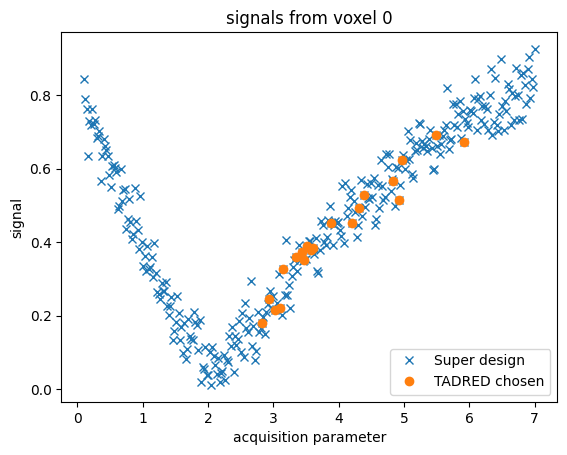

In [11]:
#plot the signals for the super design and the tadred acquisition for a single voxel

#if the number of acquisition parameters is bigger than one, need to choose which one to plot on the x axis
if (acq_params_super.ndim > 1): 
    if (acq_params_super.shape[1] > 1):
        acq_param_to_plot = 1
        acq_params_super_to_plot = acq_params_super[:,acq_param_to_plot]
        acq_params_tadred_to_plot = acq_params_tadred[:,acq_param_to_plot]
        acq_params_tadred_index_to_plot = acq_params_tadred_index[:,acq_param_to_plot]
else:
    acq_params_super_to_plot = acq_params_super
    acq_params_tadred_to_plot = acq_params_tadred
    acq_params_tadred_index_to_plot = acq_params_tadred_index
    
voxel_to_plot = 0


plt.plot(acq_params_super_to_plot, signals_super[voxel_to_plot,:], 'x')
plt.plot(acq_params_tadred_to_plot, signals_super[voxel_to_plot,acq_params_tadred_index], 'o')

plt.title('signals from voxel ' + str(voxel_to_plot))
plt.legend(('Super design', 'TADRED chosen'))
plt.ylabel('signal')
plt.xlabel('acquisition parameter')

### Cell 12: Save the chosen acquisition parameters

In [12]:
# save TADRED acquisition parameters
np.save(Path(proj_dir, "acq_params_tadred.npy"), acq_params_tadred)